# Gun Violence Capstone Project

# Inferential Statistics

The goal of this notebook is to perform inferential statistics on the Gun Violence dataset to obtain further insight in the relationship between the feature and response variables.

**0. Begin by importing relevant packages and data wrangling code.**

In [1]:
# Packages
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats
from scipy.stats import chi2
from scipy.stats import shapiro

In [2]:
df = pd.read_csv('Downloads/Data/gun-violence-data_01-2013_03-2018.csv', parse_dates=['date'])
df.drop(['incident_id','incident_url','source_url','incident_url_fields_missing','location_description','notes','participant_name','participant_relationship', 'sources', 'participant_status', 'address', 'latitude', 'longitude','participant_type','participant_age', 'gun_stolen', 'n_guns_involved'], axis = 1, inplace = True)
df.dropna(how = 'any', subset = ['incident_characteristics'], inplace = True)
df['participant_age_group'].fillna('0::Unknown', inplace = True)
def agegroup_cleanup(row):
    agegroup_row_values = []
    agegroup_row = str(row).split("||")
    for x in agegroup_row :
        agegroup_row_value = str(x).split("::")
        if len(agegroup_row_value) > 1 :
            agegroup_row_values.append(agegroup_row_value[1])
    return agegroup_row_values
agegroupvalues = df.participant_age_group.apply(agegroup_cleanup)
df["agegroup_child"] = agegroupvalues.apply(lambda x: x.count("Child 0-11"))
df["agegroup_teen"] = agegroupvalues.apply(lambda x: x.count("Teen 12-17"))
df["agegroup_adult"] = agegroupvalues.apply(lambda x: x.count("Adult 18+"))
df = df[df['incident_characteristics'].str.contains('Non-Shooting Incident') == False]
df['date'] = pd.to_datetime(df.date)
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['monthday'] = df.date.dt.day
df['weekday'] = df.date.dt.weekday
df['victims'] = df['n_injured'] + df['n_killed']
city_list = df['city_or_county'].value_counts().head(15).index.tolist()
df = df[df['city_or_county'].apply(lambda x: x in city_list)]
df['participant_gender'].fillna('0::Unknown', inplace = True)
def gender_cleanup(row):
    gender_row_values = []
    gender_row = str(row).split("||")
    for x in gender_row :
        gender_row_value = str(x).split("::")
        if len(gender_row_value) > 1 :
            gender_row_values.append(gender_row_value[1])   
    return gender_row_values
participant_genders = df.participant_gender.apply(gender_cleanup)
df["participant_gender_total"] = participant_genders.apply(lambda x: len(x))
df["participant_gender_male"] = participant_genders.apply(lambda x: x.count("Male"))
df["participant_gender_female"] = participant_genders.apply(lambda x: x.count("Female"))
df["participant_gender_unknown"] = participant_genders.apply(lambda x: x.count("Unknown"))
df['congressional_district'].fillna('Unknown', inplace = True)
df['congressional_district'] =df['congressional_district'].apply(lambda x: str(x))
df['state_house_district'].fillna('Unknown', inplace = True)
df['state_house_district'] =df['state_house_district'].apply(lambda x: str(x))
df['state_senate_district'].fillna('Unknown', inplace = True)
df['state_senate_district'] =df['state_senate_district'].apply(lambda x: str(x))
df['gun_type'].fillna('0::Unknown', inplace = True)

This inferential statistics notebook acts as a pre-cursor to the supervised machine learning algorithm that will be used to predict the number of people killed/injured based on different feature variables. Here, we will be asking a few questions:

    1) Do the response variables (n_killed, n_injured) follow a normal distribution?
    2) What do the Cumulative Distribution Functions of the response variables look like?
    3) What are the confidence intervals of the response variables?
    4) Do the response variables display dependence against the feature variables?

Let's define a few functions which will be used to perform inferential statistics.

In [3]:
# Define the cumulative distribution function, which will return the x and y values of a CDF graph.
def ecdf(data):
    n = len(data)*1.0
    x = np.sort(data)
    y= np.arange(1,n+1)/n
    return x,y

# Define the boostrap replicate function which will return the desired summary statistic of a given dataset.
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

# Define the multiple-bootstrap replicate function which will return an array of the desired sumary statistic.
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

**1. Begin by checking for Normality**

Having already plotted the histograms for n_killed and n_injured, we saw that they did not appear to follow a normal distribution but we can also perform the Shapiro-Wilk test for additional confirmation.

Let the null hypothesis be that the variable follows a normal distribution. Therefore the alternative hypothesis is that it does not follow a normal distribution.

In [4]:
# Perform the Shapiro-Wilk test 
stat, p = shapiro(df['n_killed'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpret the results
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.572, p=0.000
Sample does not look Gaussian (reject H0)


C:\Users\joshu\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1310: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [5]:
# Perform the Shapiro-Wilk test 
stat, p = shapiro(df['n_injured'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpret the results
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.722, p=0.000
Sample does not look Gaussian (reject H0)


C:\Users\joshu\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1310: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In both cases, we have a p-value of 0 and therefore we reject the null to conclude that neither follow a normal distribution.

**2. Plot the CDFs**

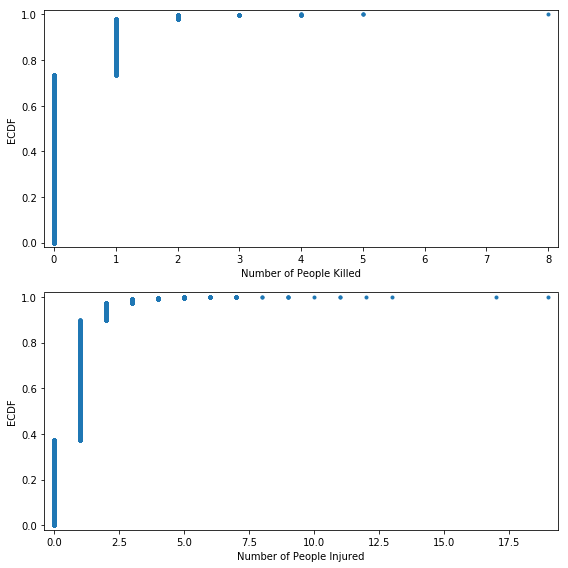

In [6]:
x,y = ecdf(df['n_killed'])

fig = plt.figure(figsize = (8,8))
_ = plt.subplot(2,1,1)
_ = plt.plot(x,y,marker='.',linestyle='none')
_ = plt.margins(0.02)
_ = plt.xlabel('Number of People Killed')
_ = plt.ylabel('ECDF')

x2, y2 = ecdf(df['n_injured'])
_ = plt.subplot(2,1,2)
_ = plt.plot(x2,y2,marker='.',linestyle='none')
_ = plt.margins(0.02)
_ = plt.xlabel('Number of People Injured')
_ = plt.ylabel('ECDF')
_ = plt.tight_layout()

As expected, the CDFs of both n_killed and n_injured are heavily skewed towards the left due to the fact that an overwhelming number of casualties are minimal. In the case of n_killed, the vast majority of incidents result in 0 deaths. For n_injured, the majority of incidents result in either 0 or 1 injuries. Beyond that are mostly incremental changes in the CDFs as a result of mostly outliers.

**3. Finding the Confidence Intervals**

In [7]:
# Calculate and store the means of the response variables
mean_k = np.mean(df['n_killed'])
mean_i = np.mean(df['n_injured'])

# Create bootstrap samples 
bs_replicates_k = draw_bs_reps(df['n_killed'],np.mean,10000)
bs_replicates_i = draw_bs_reps(df['n_injured'],np.mean,10000)

# Find the 95% confidence interval of both variables 
conf_int_k = np.percentile(bs_replicates_k,[2.5,97.5])
conf_int_i = np.percentile(bs_replicates_i,[2.5,97.5])

# Unpacking the confidence intervals and round the numbers
k1, k2 = conf_int_k
k1 = format(k1, '.3f')
k2 = format(k2, '.3f')
CI_k = [k1,k2]
CI_k
i1, i2 = conf_int_i
i1 = format(i1, '.3f')
i2 = format(i2, '.3f')
CI_i = [i1,i2]
CI_i
    
# Print the results
print('mean for n_killed =', "{0:.3f}".format(mean_k))
print('95% confidence interval for n_killed=', CI_k)

print('\nmean for n_injured =', "{0:.3f}".format(mean_i))
print('95% confidence interval for n_injured=', CI_i)

mean for n_killed = 0.284
95% confidence interval for n_killed= ['0.279', '0.289']

mean for n_injured = 0.766
95% confidence interval for n_injured= ['0.758', '0.773']


The 95% confidence interval for n_killed is [0.279, 0.289], showing that even an incident with 1 death is a big outlier. 

The 95% confidence interval for n_injured is [0.758, 0.774], so there is a little more leeway compared to n_killed but the vast majority of incidents still do not exceed 1 injury.

**4.Checking for Independence**

One of the most efficient methods for checking for independence between 2 variables is through the Chi-Square Test for Independence. The null hypothesis for each case is that the variables are independent from one another. Therefore the alternative hypothesis is that they are dependent, which is what we are looking for. If the calculated chi-square test statistic is greater than the critical value given the degrees of freedom, the null will be rejected.

In [8]:
# Define function chi2_ind that checks for independence.
def chi2_ind(x, y):
    # Use stats.chi2_contingency() to compute the test statistic, p-value, and degrees of freedom, respectively.
    a, b, c = stats.chi2_contingency(pd.crosstab(x, y))[:3]
    # Use chi2.isf() to compute the critical value given alpha = 0.01 and the computed degrees of freedom
    d = chi2.isf(q = 0.01, df = c)
    # If the critical value is less than the test-statistic AND the p-value is less than 0.01, reject the null.
    if a > d and b < 0.01:
        return True

# Define function that applies chi2_ind on n_killed and n_injured as the first argument. Check if n_killed or n_injured
# are dependent on the feature variable.
def chi2_ind_reps(x):
    if chi2_ind(df['n_killed'], x) is True and chi2_ind(df['n_injured'], x) is True:
        print('n_killed and n_injured are both dependent on', x.name)
    elif chi2_ind(df['n_killed'], x) is True and chi2_ind(df['n_injured'], x) is False:
        print('Only n_killed is dependent on', x.name)
    elif chi2_ind(df['n_killed'], x) is False and chi2_ind(df['n_injured'], x) is True:
        print('Only n_injured is dependent on', x.name)
    else:
        print('Neither are dependent on', x.name)

# Create a list of the feature variables
feat_var = [df['city_or_county'], df['year'], df['participant_gender_female'], df['participant_gender_male'], 
            df['agegroup_adult'], df['agegroup_child'], df['agegroup_teen'], df['incident_characteristics'],
            df['gun_type'], df['congressional_district'], df['state_house_district'], df['state_senate_district']
           ]

In [9]:
# Apply chi2_ind_reps to the feat_var list
list(map(chi2_ind_reps, feat_var))

n_killed and n_injured are both dependent on city_or_county
n_killed and n_injured are both dependent on year
n_killed and n_injured are both dependent on participant_gender_female
n_killed and n_injured are both dependent on participant_gender_male
n_killed and n_injured are both dependent on agegroup_adult
n_killed and n_injured are both dependent on agegroup_child
n_killed and n_injured are both dependent on agegroup_teen
n_killed and n_injured are both dependent on incident_characteristics
Neither are dependent on gun_type
n_killed and n_injured are both dependent on congressional_district
n_killed and n_injured are both dependent on state_house_district
n_killed and n_injured are both dependent on state_senate_district


[None, None, None, None, None, None, None, None, None, None, None, None]

With the exception of gun_type, the response variables (n_killed and n_injured) showed dependence against all the other feature variables. Therefore, we can use these feature variables for the machine learning algorithm. 